In [3]:
def text2int(textnum, numwords={}):
    if textnum=='?': return '?'
    if not numwords:
      units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
      ]

      tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

      scales = ["hundred", "thousand", "million", "billion", "trillion"]

      numwords["and"] = (1, 0)
      for idx, word in enumerate(units):    numwords[word] = (1, idx)
      for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
      for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
          raise Exception("Illegal word: " + word)

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

def mean_impute(df, col, missing_value = '?', data_type='int'):
    s = df[col].loc[df[col] != missing_value]
    if data_type=='int':
        mean = s.astype(str).astype(int).mean()
        return df[col].replace(missing_value,mean).astype(int)
    elif data_type=='float':
        mean = s.astype(str).astype(float).mean()
        return df[col].replace(missing_value,mean).astype(float)
    else:
        raise Exception()

In [5]:
import pandas as pd
import numpy as np

col_names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', \
'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', \
'length', 'width', 'height', 'curb-weight', 'engine-type', \
'num-of-cylinders','engine-size', 'fuel-system', 'bore', 'stroke', \
'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', \
'price']

col_types = ['int', 'int', 'str', 'str', 'str', \
'int', 'str', 'str', 'str', 'float', \
'float', 'float', 'float', 'int', 'str', \
'int', 'int', 'str', 'float', 'float', \
'float', 'int', 'int', 'int', 'int', \
'int']

automobile = pd.read_csv('data/imports-85.data', names=col_names)

# apply text2int for num-of-doors and num-of-cylinders
for each in ['num-of-doors', 'num-of-cylinders']:
    automobile[each] = automobile[each].apply(text2int)

# impute missing values
null_sum = automobile.replace('?', np.nan).isnull().sum()
null_col = [k for k,v in null_sum.iterkv() if v!=0]
for each_col_ind, each_col in enumerate(col_names):
    if each_col in null_col and col_types[each_col_ind]!='str':
        automobile[each_col] = mean_impute(automobile, each_col, data_type=col_types[each_col_ind])

# ignore symboling column
automobile = automobile.drop('symboling', axis=1)

# label encoding from categorical values to integer
from sklearn import preprocessing
les = {}
automobile_lencoded = automobile.copy()
for each_col_ind, each_col in enumerate(col_names):
    if col_types[each_col_ind] == 'str':
        le = preprocessing.LabelEncoder()
        le.fit(automobile[each_col])
        les[each_col] = le
        automobile_lencoded[each_col] = le.transform(automobile[each_col])

X = automobile_lencoded.drop(['normalized-losses'], axis=1)
Y = automobile_lencoded['normalized-losses']

import matplotlib.pyplot as plt
% matplotlib inline

/Users/sanari85/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: iterkv is deprecated and will be removed in a future release, use ``iteritems`` instead.


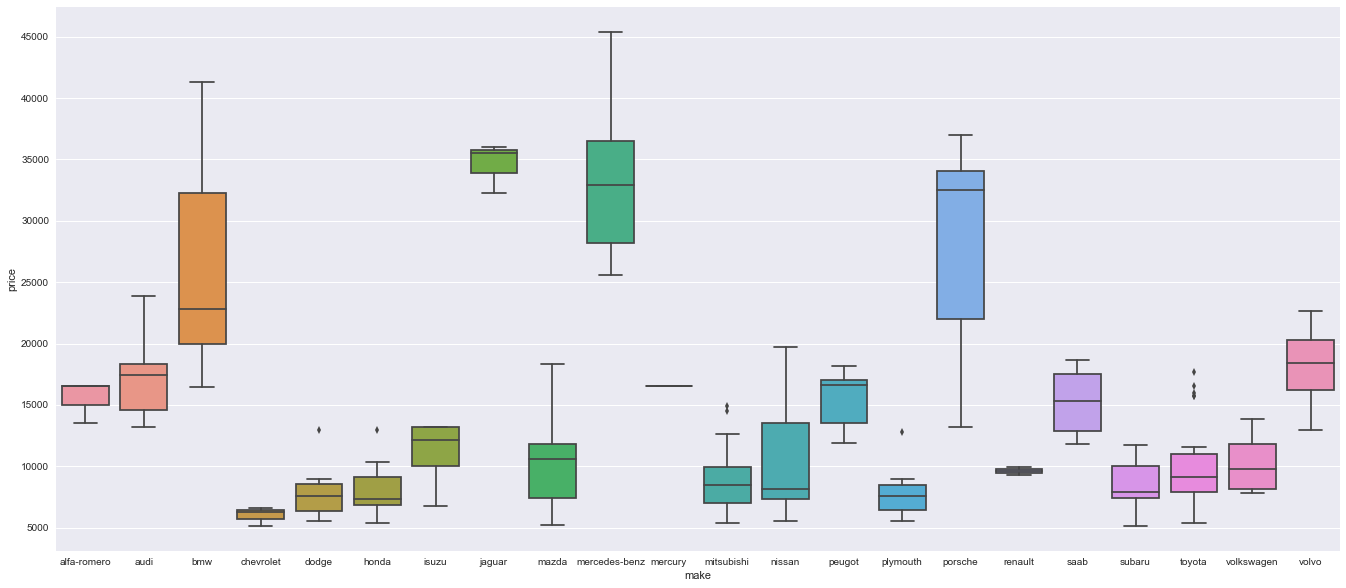

In [6]:
import seaborn as sns
plt.rcParams['figure.figsize']=(23,10)
ax = sns.boxplot(x="make", y="price", data=automobile)

In [16]:
from sklearn.cross_validation import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

from math import sqrt
from copy import deepcopy

kernel = 1 * RBF(1, (1e-3, 1e3))
    
def loop_byrec(k, finalK, params, regr, cv_data, res, partial=[]):
    if len(partial) == finalK:
        if regr=='Ridge':
            predictor = Ridge(alpha=partial[0])
        elif regr=='KernelRidgeLinear':
            predictor = KernelRidge(alpha = partial[0])
        elif regr=='KernelRidgeRBF':
            predictor = KernelRidge(alpha = partial[0], kernel='rbf', gamma=partial[1])
        elif regr=='GPR':
            global kernel
            kernel = 1 * RBF(partial[1], (1e-4, 1e4))
            predictor = GaussianProcessRegressor(alpha = partial[0], kernel=kernel)
        else:
            raise Exception()
        cv_train_data = cv_data[0]
        cv_train_y = cv_data[1]
        cv_test_data = cv_data[2]
        cv_test_y = cv_data[3]
        predictor.fit(cv_train_data, cv_train_y)
        predicted = predictor.predict(cv_test_data)
        res.append((sqrt(sum(pow(i-j, 2) for i, j in zip(predicted, cv_test_y))), deepcopy(partial)))
    else:
        for each_param in params[k]:
            partial.append(each_param)
            loop_byrec(k+1, finalK, params, regr, cv_data, res, partial)
            partial.pop()


(139.62265272148105, [0.1])
(146.2234054721146, [100])
(113.30765771137497, [10])
(141.34750269185824, [1e-10])
(187.51552713835187, [100])
Ridge 890.474176897


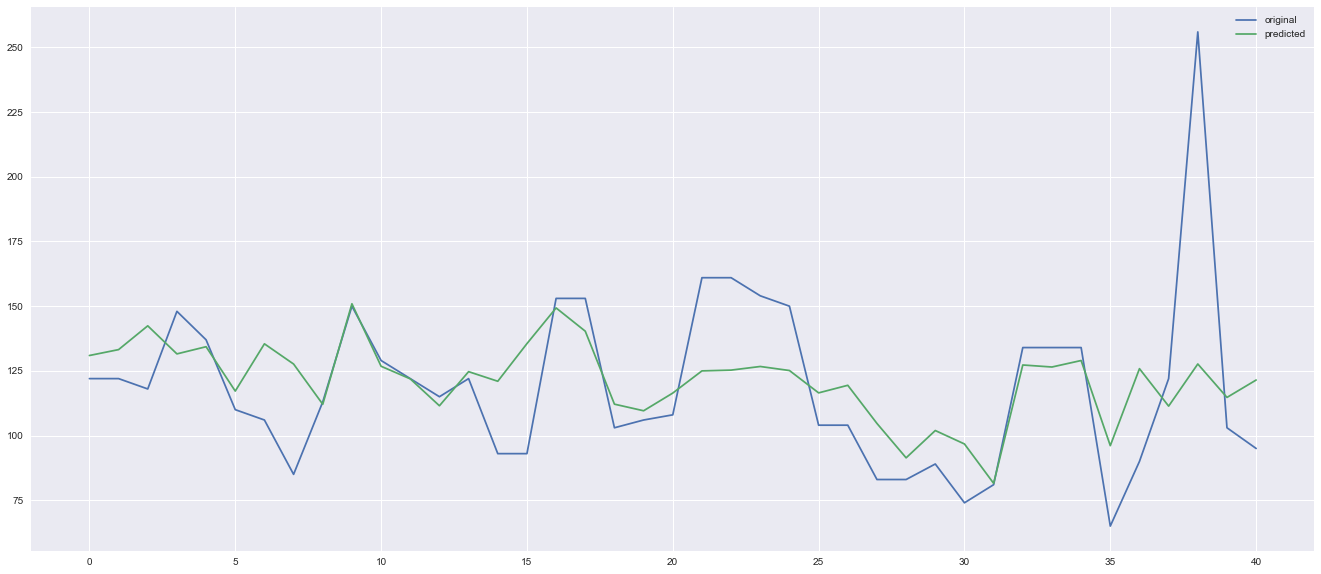

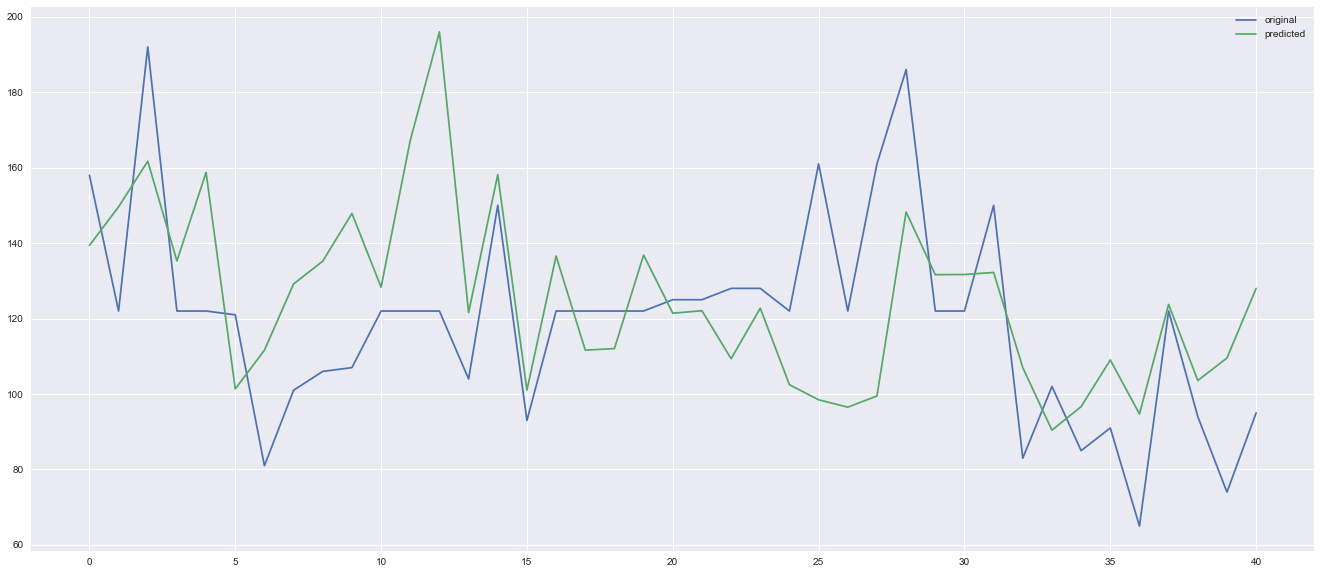

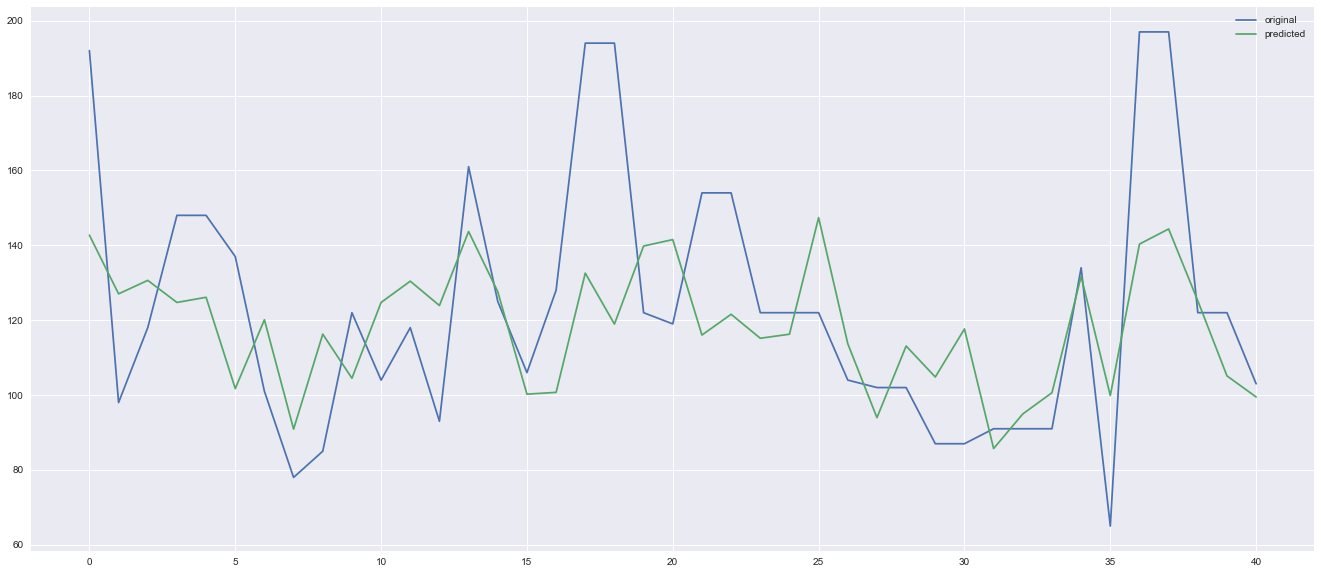

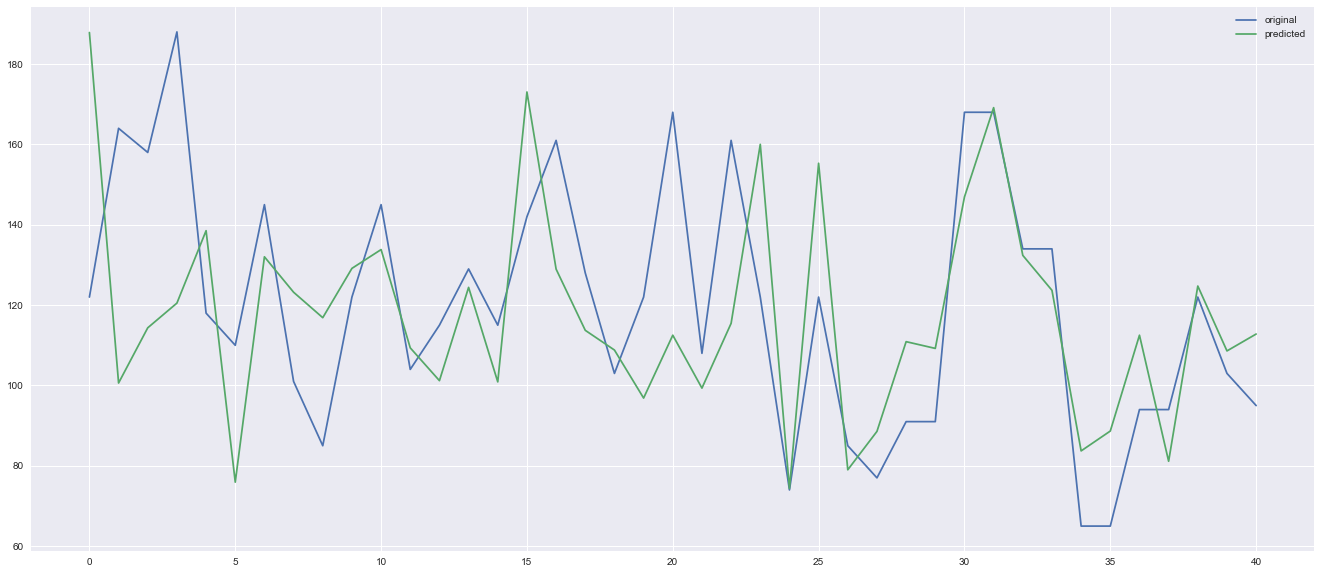

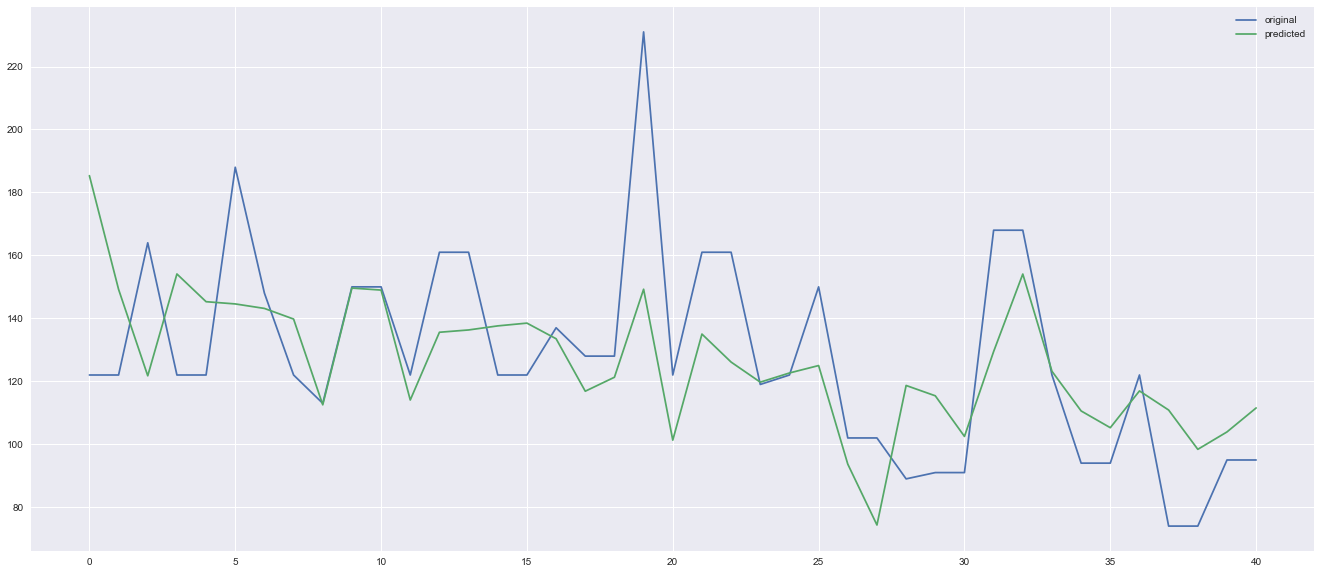

In [17]:
total_err = 0
n_folds = 5
kf = KFold(n = len(X), n_folds=n_folds, shuffle=True)
# regrs = ['LinearRegression', 'Ridge', 'KernelRidgeLinear', 'KernelRidgeRBF', 'GPR']
regrs = ['Ridge']
# regrs_params = [\
#                 [], \
#                 [[pow(10, i) for i in range(-10, 11)]], \
#                 [[pow(10, i) for i in range(-10, 11)]] , \
#                 [[pow(10, i) for i in range(-30, -4)], [pow(10, i) for i in range(-30, -4)]], \
#                 [[pow(10, i) for i in range(-5, 6)], [pow(10, i) for i in range(-5, 6)]] \
#                ]
regrs_params = [\
                [[pow(10, i) for i in range(-10, 11)]], \
               ]
regrs_lenParam = [len(i) for i in regrs_params]

for regr_ind, regr in enumerate(regrs):
    total_err = 0.
    for itera in range(1):
        for train_index, test_index in kf:
            train_data = np.array(X.iloc[train_index])
            test_data = np.array(X.iloc[test_index])
            train_y = np.array(Y.iloc[train_index])
            test_y = np.array(Y.iloc[test_index])
            kf2 = KFold(n = len(train_data), n_folds=n_folds, shuffle=True)
            if regrs_lenParam[regr_ind] != 0:
                best_errs = [float('inf'), []]
                for cv_train_ind, cv_test_ind in kf2:
                    cv_train_data = train_data[cv_train_ind]
                    cv_train_y = train_y[cv_train_ind]
                    cv_test_data = train_data[cv_test_ind]
                    cv_test_y = train_y[cv_test_ind]

                    errs = []
                    loop_byrec(0, regrs_lenParam[regr_ind], regrs_params[regr_ind], regr, \
                               [cv_train_data, cv_train_y, cv_test_data, cv_test_y], errs)
                    
                    sorted_errs = sorted(errs, key=lambda x:x[0])
                    if sorted_errs[0][0] < best_errs[0]:
                        best_errs = sorted_errs[0]
            if regr == 'Ridge':
                predictor = Ridge(alpha = best_errs[1][0])
            elif regr == 'LinearRegression':
                predictor = linear_model.LinearRegression()
            elif regr == 'KernelRidgeLinear':
                predictor = KernelRidge(alpha = best_errs[1][0])
            elif regr == 'KernelRidgeRBF':
                predictor = KernelRidge(alpha = best_errs[1][0], kernel='rbf', gamma = best_errs[1][1])
            elif regr == 'GPR':
                global kernel
                kernel = 1 * RBF(best_errs[1][1], (1e-4, 1e4))
                predictor = GaussianProcessRegressor(alpha = best_errs[1][0], kernel=kernel)
            else:
                raise Exception()
            predictor.fit(train_data, train_y)
            predicted = predictor.predict(test_data)
            total_err += sqrt(sum(pow(i-j, 2) for i, j in zip(predicted, test_y)))
            if regr == 'Ridge':
                plt.figure()
                plt.plot(test_y, label='original')
                plt.plot(predicted, label='predicted')
                plt.legend()
                print sorted_errs[0]
    print regr, total_err
